
# Project: Traffic Sign Classification



---
## Step 0: Load The Data

In [1]:

# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
validation_file='traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

### Basic Summary

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)
n_validation = len(X_validation)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory Visualization

Mean (Number of training samples per class): 809.279069767


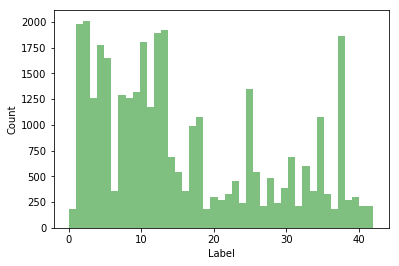

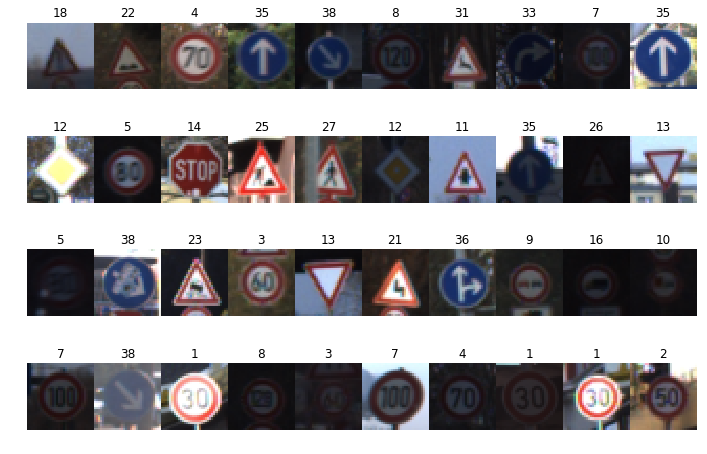

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

print ('Mean (Number of training samples per class): ' + str(np.mean(np.bincount(y_train))) )
#Plot Frequency Histogram
plt.hist(y_train, n_classes, facecolor='green', alpha=0.5)
plt.xlabel('Label')
plt.ylabel('Count')

'''
Plots m * n images in a m * n grid
Picks examples from the training pool
'''
def plot_examples (m, n):
    fig, axs = plt.subplots(m,n, figsize=(12, 8))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
    for i in range(m*n):
        index = random.randint(0, len(X_train))
        image = X_train[index]
        axs[i].axis('off')
        axs[i].imshow(image)
        axs[i].set_title(y_train[index])

plot_examples(4, 10)




## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

Shape Original: (34799, 32, 32, 3)
Modified Shape: (34799, 32, 32, 1)
37


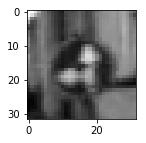

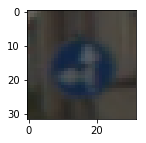

In [4]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def to_grayscale(dataset):
    return np.sum (dataset/3, axis=3, keepdims=True)

X_train_origianl = X_train
X_train_gray = to_grayscale(X_train)

X_test_origianl = X_test
X_test_gray = to_grayscale(X_test)

X_validation_origianl = X_validation
X_validation_gray = to_grayscale(X_validation)

X_train = X_train_gray
X_test = X_test_gray
X_validation = X_validation_gray

print('Shape Original:', X_train_origianl.shape)
print('Modified Shape:', X_train.shape)

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
image_original = X_train_origianl[index].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image, cmap="gray")

plt.figure(figsize=(2,2))
plt.imshow(image_original)

print(y_train[index])

In [5]:
#Normalize the sets
X_train = (X_train - 128)/128 
X_test = (X_test - 128)/128
X_validation = (X_validation - 128)/128

In [6]:
#Augment modified images in the training set
from image_modification import get_translated,get_scaled, get_warped, get_brightened

print('X, y shapes (Before Augmentation):', X_train.shape, y_train.shape)

#input and output induces
in_ind = []
out_ind = []
mean_freq = int (np.mean(np.bincount(y_train)))
for class_n in range(n_classes):
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < mean_freq:
        for i in range(mean_freq - n_samples):
            in_ind.append(class_indices[0][i%n_samples])
            out_ind.append(X_train.shape[0])
            new_img = X_train[class_indices[0][i % n_samples]]
            new_img = get_translated(get_scaled(get_warped(get_brightened(new_img))))
            X_train = np.concatenate((X_train, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            
print('X, y shapes (After Augmentation):', X_train.shape, y_train.shape)


X, y shapes (Before Augmentation): (34799, 32, 32, 1) (34799,)
X, y shapes (After Augmentation): (46714, 32, 32, 1) (46714,)


In [7]:
#Shuffle training data
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

In [8]:
import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 64

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Dropout
    conv1 = tf.nn.dropout(conv1, keep_prob)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Dropout
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # TODO: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # TODO: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, conv1, conv2

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

In [11]:
rate = 0.001

logits, conv1, conv2 = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

Training...
Done ..!!
Model saved


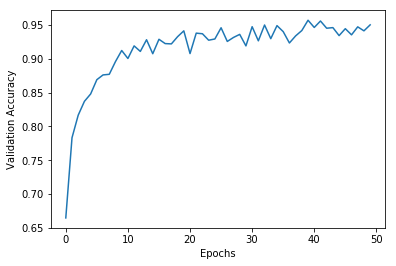

In [13]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    validation_accuracy_log = []
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        validation_accuracy = evaluate(X_validation, y_validation)
        validation_accuracy_log.append(float(validation_accuracy))

    print('Done ..!!')
    saver.save(sess, './lenet')
    print("Model saved")
    
    plt.plot(validation_accuracy_log)
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.show()
    

In [14]:
#Test set Evaluation

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.932


## Step 3: Test a Model on New Images


### Load and Output the Images

(5, 32, 32, 1)


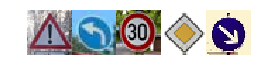

In [15]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Load the images and plot them here.
### Feel free to use as many code cells as needed.

#reading in an image
import cv2
import glob
import matplotlib.image as mpimg

fig, axs = plt.subplots(1,5, figsize=(4, 2))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('internet_data/*.png')):
    image = cv2.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    my_images.append(image)

my_images_original = np.asarray(my_images)
my_images = np.sum(my_images_original/3, axis=3, keepdims=True)
my_images = (my_images - 128)/128 

print(my_images.shape)

### Predict the Sign Type for Each Image

In [16]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
my_labels = [18, 34, 1, 12, 38]


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./lenet.meta')
    saver3.restore(sess, "./lenet")
    my_accuracy = evaluate(my_images, my_labels)
    print("Test Set Accuracy = {:.3f}".format(my_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Set Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [17]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_images, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: my_images, keep_prob: 1.0})


INFO:tensorflow:Restoring parameters from ./lenet


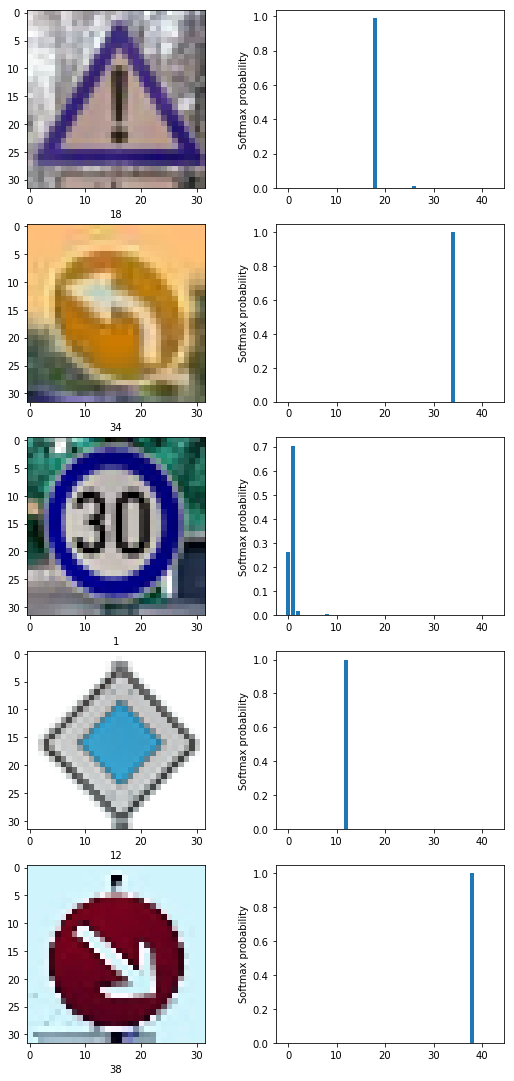

In [18]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
fig, axs = plt.subplots(5,2, figsize=(9, 19))
axs = axs.ravel()

for i in range(len(my_softmax_logits)*2):
    if i%2 == 0:
        axs[i].set_xlabel(str(my_labels[i//2]))
        axs[i].imshow(my_images_original[i//2])
        
    else:
        axs[i].bar(np.arange(n_classes), my_softmax_logits[(i-1)//2]) 
        axs[i].set_ylabel('Softmax probability')
        

In [20]:
#outputFeatureMap(X_train[1], conv1, -1, -1 ,1)
print(tf.__version__)

1.0.0


### Project Report

[Read the full report here](https://github.com/rajesh-iiith/Machine-Learning-Nanodegree/blob/master/Project-5/project_report.md).